In [ ]:
from dataclasses import dataclass
import os

import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Config

@dataclass
class Config:
  batch_size = 32
  dropout_p = 0

In [ ]:
# Function to return a Dataset object from a dataset path

def load_landmark_csv(filepath):
    # Hardcoded label to index mapping
    label_to_index = {
      "anger": 0,
      "disgust": 1,
      "fear": 2,
      "happy": 3,
      "sadness": 4,
      "surprise": 5,
      "neutral": 6,
      "contempt": 7,
    }

    # Load the CSV
    df = pd.read_csv(filepath)

    # Extract features (exclude image_name and emotion)
    feature_cols = df.columns[1:-1]
    features = torch.tensor(df[feature_cols].values, dtype=torch.float32)

    # Map emotion labels to class indices
    labels = df["emotion"].map(label_to_index).values
    labels = torch.tensor(labels, dtype=torch.long)

    dataset = TensorDataset(features, labels)

    return dataset

In [ ]:
# Get the dataset paths

# Mount Google Drive
drive.mount('/content/drive')

# Define the dataset path
dataset_path = "/content/drive/My Drive/Colab Notebooks/CK+ Dataset/"

# Define the Train, Validation, and Test paths
train_path = os.path.join(dataset_path, "features_train.csv")
val_path = os.path.join(dataset_path, "features_val.csv")
test_path = os.path.join(dataset_path, "features_test.csv")

# Print the Train, Validation, and Test paths
print(f"Train Path: {train_path}")
print(f"Validation Path: {val_path}")
print(f"Test Path: {test_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train Path: /content/drive/My Drive/Colab Notebooks/CK+ Dataset/features_train.csv
Validation Path: /content/drive/My Drive/Colab Notebooks/CK+ Dataset/features_val.csv
Test Path: /content/drive/My Drive/Colab Notebooks/CK+ Dataset/features_test.csv


In [ ]:
label_to_index = {
      "anger": 0,
      "disgust": 1,
      "fear": 2,
      "happy": 3,
      "sadness": 4,
      "surprise": 5,
      "neutral": 6,
      "contempt": 7,
    }

# Load the CSV
df = pd.read_csv(val_path)

# Map emotion labels to class indices
# labels = df["emotion"].map(label_to_index).values
set(df["emotion"])

{'anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'}

In [ ]:
# Create DataLoaders for Train, Validation, and Test splits

def create_loaders(batch_size):
  # Create the trainloader from the Train split
  trainset = load_landmark_csv(train_path)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
  # Create the valloader from the Validation split
  valset = load_landmark_csv(val_path)
  valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
  # Create the testloader from the Test split
  testset = load_landmark_csv(test_path)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
  return trainloader, valloader, testloader

In [ ]:
# Function to build an MLP model

def build_mlp(config):

  class MLP(nn.Module):
      def __init__(self):
          super().__init__()
          self.fc1 = nn.Linear(25, 20)
          self.fc2 = nn.Linear(20, 15)
          self.fc3 = nn.Linear(15, 8)

      def forward(self, x):
          x = F.dropout(F.relu(self.fc1(x)), p=config.dropout_p)
          x = F.dropout(F.relu(self.fc2(x)), p=config.dropout_p)
          x = self.fc3(x)
          return x

  return MLP()

In [ ]:
# Train the model

def train(mlp, epochs, trainloader, valloader):
  for epoch in range(epochs):  # loop over the dataset multiple times
      mlp.train()
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          features, labels = data
          features, labels = features.to(device), labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = mlp(features)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      avg_loss = running_loss / len(trainloader)
      print(f'Epoch [{epoch + 1}/{epochs}] - Loss: {avg_loss:.4f}')

  print('Finished Training')

  mlp.eval()
  min_val_loss = float('inf')
  with torch.no_grad():
      for val_features, val_labels in valloader:
        val_features, val_labels = val_features.to(device), val_labels.to(device)
        val_outputs = mlp(val_features)
        val_loss = criterion(val_outputs, val_labels).item()
        if val_loss < min_val_loss:
            min_val_loss = val_loss # update best val loss

  print(f"Min val loss was {min_val_loss:.4f}")

  return min_val_loss

In [ ]:
# Create an MLP, define the Loss function and optimizer, and train the model

config = Config
trainloader, valloader, testloader = create_loaders(config.batch_size)
mlp = build_mlp(config).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)

epochs = 1000
min_val_loss = train(mlp, epochs, trainloader, valloader)

Epoch [1/1000] - Loss: 2.1555
Epoch [2/1000] - Loss: 2.1302
Epoch [3/1000] - Loss: 2.0994
Epoch [4/1000] - Loss: 2.0768
Epoch [5/1000] - Loss: 2.0509
Epoch [6/1000] - Loss: 2.0350
Epoch [7/1000] - Loss: 2.0153
Epoch [8/1000] - Loss: 2.0003
Epoch [9/1000] - Loss: 1.9813
Epoch [10/1000] - Loss: 1.9668
Epoch [11/1000] - Loss: 1.9494
Epoch [12/1000] - Loss: 1.9371
Epoch [13/1000] - Loss: 1.9220
Epoch [14/1000] - Loss: 1.9073
Epoch [15/1000] - Loss: 1.8948
Epoch [16/1000] - Loss: 1.8844
Epoch [17/1000] - Loss: 1.8788
Epoch [18/1000] - Loss: 1.8644
Epoch [19/1000] - Loss: 1.8598
Epoch [20/1000] - Loss: 1.8488
Epoch [21/1000] - Loss: 1.8433
Epoch [22/1000] - Loss: 1.8435
Epoch [23/1000] - Loss: 1.8278
Epoch [24/1000] - Loss: 1.8323
Epoch [25/1000] - Loss: 1.8223
Epoch [26/1000] - Loss: 1.8237
Epoch [27/1000] - Loss: 1.8128
Epoch [28/1000] - Loss: 1.8055
Epoch [29/1000] - Loss: 1.8141
Epoch [30/1000] - Loss: 1.8131
Epoch [31/1000] - Loss: 1.8038
Epoch [32/1000] - Loss: 1.8054
Epoch [33/1000] -

Test Loss: 0.6713


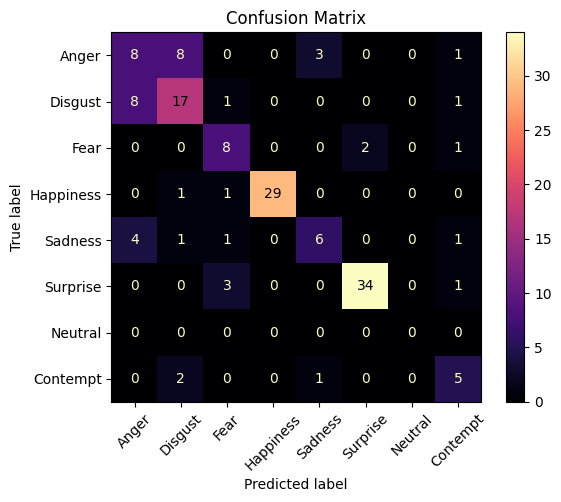

In [ ]:
# Define class names and label indices
class_names = ["Anger", "Disgust", "Fear", "Happiness", "Sadness", "Surprise", "Neutral", "Contempt"]
label_order = list(range(len(class_names)))  # Create a list of indices for all classes

# Initialize
mlp.eval()
running_test_loss = 0.0
all_preds = []
all_labels = []

# No gradient calculation during evaluation
with torch.no_grad():
    for test_features, test_labels in testloader:
        test_features, test_labels = test_features.to(device), test_labels.to(device)
        test_outputs = mlp(test_features)
        test_loss = criterion(test_outputs, test_labels)
        running_test_loss += test_loss.item()

        # Get predicted class indices (max value along the classes dimension)
        preds = torch.argmax(test_outputs, dim=1)

        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

# Compute average test loss
avg_test_loss = running_test_loss / len(testloader)
print(f"Test Loss: {avg_test_loss:.4f}")

# Compute and display confusion matrix with fixed class labels order
cm = confusion_matrix(all_labels, all_preds, labels=label_order)

# Create and display confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='magma', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
